# Bangkit Final Project: Garbage Classification with Machine Learning

Repository : https://github.com/reevald/craftivity-data

## Import Libraries

In [ ]:
import zipfile
import os
import random
import math
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn import metrics
from google.colab import files
from shutil import copyfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Preparation Data with ETL (Extract, Transform, Load)

### Extract Dataset

Source dataset (TrashNet) : https://github.com/garythung/trashnet

In [ ]:
# Downloading the Dataset
!wget --no-check-certificate \
  https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip \
  -O /tmp/trashnet.zip

--2021-05-30 04:21:06--  https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42834870 (41M) [application/zip]
Saving to: ‘/tmp/trashnet.zip’

/tmp/trashnet.zip   100%[===================>]  40.85M   119MB/s    in 0.3s    

2021-05-30 04:21:08 (119 MB/s) - ‘/tmp/trashnet.zip’ saved [42834870/42834870]



In [ ]:
# Extract the downloaded zip file
local_zip = "/tmp/trashnet.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

# Check the number of datasets
base_dir_ori = "/tmp/dataset-resized"
label = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
list_ori_dir = [base_dir_ori+"/"+lb for lb in label]
for i in range(len(label)):
  print("Data {} : {}".format(label[i], len(os.listdir(list_ori_dir[i]))))

# Preparation of split by configuring directories
base_dir = "/tmp/data"
train_dir = base_dir + "/train"
test_dir = base_dir + "/test"
val_dir = base_dir + "/val"

try:
  # Create directory
  os.mkdir(base_dir)
  for par_dir in [train_dir, test_dir, val_dir]:
    os.mkdir(par_dir)
    for ch_dir in [par_dir+"/"+lb for lb in label]:
      os.mkdir(ch_dir)
  print("\nCreate directory successfully!")
except OSError as e:
  print("\nUnable create directory. {}".format(e))

Data cardboard : 403
Data glass : 501
Data metal : 410
Data paper : 594
Data plastic : 482
Data trash : 137

Create directory successfully!


#### Split Dataset

In [ ]:
split = {
         'train' : 0.7,
         'test' : 0.15,
         'val' : 0.15
         }

def split_data(list_class_dir, train_dir, test_dir, val_dir, dict_split, label):
  # Split data for each class
  for idx_lb,class_dir in enumerate(list_class_dir):
    list_img = os.listdir(class_dir)
    list_img = random.sample(list_img, len(list_img))
    if (dict_split['train']+dict_split['test']+dict_split['val']==1.0):
      num_val = math.floor(dict_split['val'] * len(list_img))
      num_test = math.floor(dict_split['test'] * len(list_img))
      num_train = len(list_img) - num_val - num_test
      for i in range(len(list_img)):
        # Check image
        size_file_img = os.path.getsize(class_dir+"/"+list_img[i])
        if (size_file_img == 0):
          continue
        if (i < num_val):
          # Copy to val dir
          dest_dir = val_dir
        elif (i >= num_val and i < num_val + num_test):
          # Copy to test dir
          dest_dir = test_dir
        else:
          # Copy to train dir
          dest_dir = train_dir
        try:
          copyfile(class_dir+"/"+list_img[i], dest_dir+"/"+label[idx_lb]+"/"+list_img[i])
        except IOError as e:
          return "Unable to copy file. {}".format(e)
    else:
      return "Incorrect data split!"

    print("{} : train({}), test({}), val({})".format(
        label[idx_lb],
        len(os.listdir(train_dir+"/"+label[idx_lb])),
        len(os.listdir(test_dir+"/"+label[idx_lb])),
        len(os.listdir(val_dir+"/"+label[idx_lb]))
    ))

# Check the split results
split_data(
    list_class_dir=[base_dir_ori+"/"+lb for lb in label],
    train_dir=train_dir,
    test_dir=test_dir,
    val_dir=val_dir,
    dict_split=split,
    label=label
)

cardboard : train(283), test(60), val(60)
glass : train(351), test(75), val(75)
metal : train(288), test(61), val(61)
paper : train(416), test(89), val(89)
plastic : train(338), test(72), val(72)
trash : train(97), test(20), val(20)


TODO : Create visualize distribution

Delete data (if there are errors or duplicate files) and start from the configuration directory  
`%rm -rf "/tmp/data"`

### Transform Dataset

Reference for batch size, epoch, and learning rate :  
https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e  


In [ ]:
# Corresponds to a lot of data
batch_train = 32 # Alternative : 8,16,32,64
batch_val = 16
batch_test = 16
size_input = (224, 224)

# Normalize image
valtest_datagen = ImageDataGenerator(rescale=1./255.)

#### Augmentation

Reference for augmentation :  
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [ ]:
# Image augmentation (optional to improve accuracy)
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

### Load Dataset

In [ ]:
# Train Generator
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size=batch_train,
    class_mode='categorical',
    target_size=size_input
)

# Test Generator
test_generator = valtest_datagen.flow_from_directory(
    directory=test_dir,
    batch_size=batch_test,
    class_mode='categorical',
    target_size=size_input
)

# Val Generator
val_generator = valtest_datagen.flow_from_directory(
    directory=val_dir,
    batch_size=batch_val,
    class_mode='categorical',
    target_size=size_input
)

Found 1773 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


#### Visualize Data

Reference subplot multi image :  
https://matplotlib.org/stable/gallery/images_contours_and_fields/multi_image.html

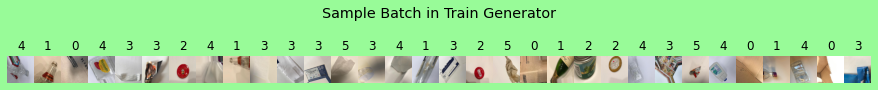

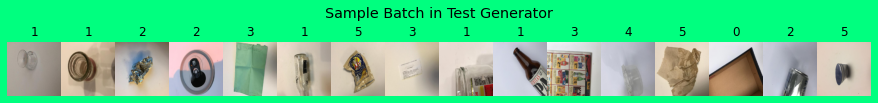

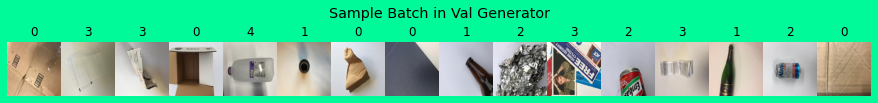

In [ ]:
# Take a sample batch file
idx_train = random.randrange(len(train_generator))
idx_test = random.randrange(len(test_generator))
idx_val = random.randrange(len(val_generator))

# Displays an image with label for the train, test and val generator
list_train_img, list_train_lb = train_generator[idx_train]
list_test_img, list_test_lb = test_generator[idx_test]
list_val_img, list_val_lb = val_generator[idx_val]

# The number of images must be less than or equal to the batch size
def show_img_horizontal(title, color, list_img, list_lb, num_img):
  fig = plt.figure(figsize=(12,1.8), facecolor=color)
  fig.suptitle(title, fontsize='x-large')
  axs = fig.subplots(1, num_img)
  fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
  for i in range(num_img):
    axs[i].imshow(list_img[i])
    axs[i].axis('off')
    axs[i].title.set_text(np.argmax(list_lb[i]))

# Show image in train generator
show_img_horizontal(
    'Sample Batch in Train Generator',
    'palegreen',
    list_train_img,
    list_train_lb,
    batch_train
)
# Show image in test generator
show_img_horizontal(
    'Sample Batch in Test Generator',
    'springgreen',
    list_test_img,
    list_test_lb,
    batch_test
)
# Show image in test generator
show_img_horizontal(
    'Sample Batch in Val Generator',
    'mediumspringgreen',
    list_val_img,
    list_val_lb,
    batch_val
)

<table>
  <tr>
    <th colspan="6">Label Code</th>
  </tr>
  <tr align="center">
    <td>0</td>
    <td>1</td>
    <td>2</td>
    <td>3</td>
    <td>4</td>
    <td>5</td>
  </tr>
  <tr>
    <td>Cardboard</td>
    <td>Glass</td>
    <td>Metal</td>
    <td>Paper</td>
    <td>Plastic</td>
    <td>Trash</td>
  </tr>
</table>

## Define Model with Basic CNN and DNN

In [ ]:
# Basic Neural Network
model = tf.keras.models.Sequential([
    # CNN
    tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=size_input+(3,)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    # DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(6, activation="softmax")
])

model.summary()
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.001) #Default
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

### Training Model

In [ ]:
history = model.fit(
    train_generator,
    epochs=30,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    verbose=1
)

Epoch 1/30
56/56 [==============================] - 103s 2s/step - loss: 1.7466 - acc: 0.2967 - val_loss: 1.3929 - val_acc: 0.3979
Epoch 2/30
56/56 [==============================] - 105s 2s/step - loss: 1.4048 - acc: 0.4179 - val_loss: 1.3361 - val_acc: 0.4509
Epoch 3/30
56/56 [==============================] - 103s 2s/step - loss: 1.2709 - acc: 0.4969 - val_loss: 1.0983 - val_acc: 0.5279
Epoch 4/30
56/56 [==============================] - 102s 2s/step - loss: 1.2174 - acc: 0.5166 - val_loss: 1.0441 - val_acc: 0.5676
Epoch 5/30
56/56 [==============================] - 102s 2s/step - loss: 1.1112 - acc: 0.5792 - val_loss: 1.0920 - val_acc: 0.5703
Epoch 6/30
56/56 [==============================] - 102s 2s/step - loss: 1.1037 - acc: 0.5883 - val_loss: 0.9428 - val_acc: 0.6260
Epoch 7/30
56/56 [==============================] - 101s 2s/step - loss: 1.0521 - acc: 0.6103 - val_loss: 1.1214 - val_acc: 0.5968
Epoch 8/30
56/56 [==============================] - 102s 2s/step - loss: 1.0837 - a

### Plot Accuracy and Lose

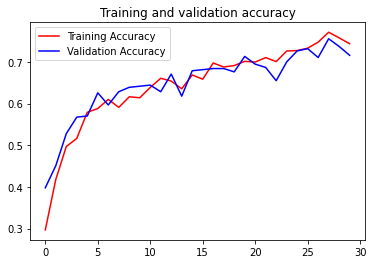

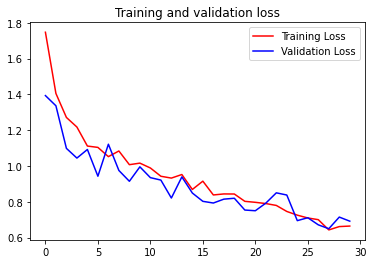

In [ ]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Test Accuracy Model

In [ ]:
loss = model.evaluate(test_generator, steps=len(test_generator))

24/24 [==============================] - 6s 238ms/step - loss: 0.7080 - acc: 0.7454


## Improve Model with Transfer Learning (with MobileNet v2)

Why MobileNet v2?  
The main reason is because MobileNetv2 is lightweight for deployment to smartphones (tflite) ~ 14 MB  

Reference : 
- https://keras.io/api/applications/#usage-examples-for-image-classification-models
- https://keras.io/guides/transfer_learning/
- https://analyticsindiamag.com/a-practical-guide-to-implement-transfer-learning-in-tensorflow/#:~:text=Transfer%20Learning%20With%20MobileNet%20V2,images%20of%20cats%20and%20dogs.

### Create and Train Model

First, instantiate a base model with pre-trained weights.

In [ ]:
# The base model is the model that is pre-trained. 
# We will create a base model using MobileNet V2.

base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=size_input+(3,),
    include_top=False  # Do not include the ImageNet classifier at the top.
)

9412608/9406464 [==============================] - 0s 0us/step


Then, freeze the base model.

In [ ]:
# To prevent the weights of the convolution from being updated before the model is compiled and trained.
base_model.trainable = True

Create a new model on top.

In [ ]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(6, activation='softmax')]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 2,231,558
Non-trainable params: 34,112
_________________________________________________________________


Train the model on new data.

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5), # Low learning rate
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

history = model.fit(
    train_generator,
    epochs=30,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    verbose=1
)

Epoch 1/30
56/56 [==============================] - 328s 6s/step - loss: 1.7466 - categorical_accuracy: 0.2984 - val_loss: 1.7729 - val_categorical_accuracy: 0.2546
Epoch 2/30
56/56 [==============================] - 320s 6s/step - loss: 1.3750 - categorical_accuracy: 0.5003 - val_loss: 1.5294 - val_categorical_accuracy: 0.3846
Epoch 3/30
56/56 [==============================] - 319s 6s/step - loss: 1.1383 - categorical_accuracy: 0.6097 - val_loss: 1.3559 - val_categorical_accuracy: 0.4642
Epoch 4/30
56/56 [==============================] - 318s 6s/step - loss: 1.0023 - categorical_accuracy: 0.6526 - val_loss: 1.2456 - val_categorical_accuracy: 0.5146
Epoch 5/30
56/56 [==============================] - 318s 6s/step - loss: 0.8968 - categorical_accuracy: 0.7073 - val_loss: 1.1584 - val_categorical_accuracy: 0.5570
Epoch 6/30
56/56 [==============================] - 320s 6s/step - loss: 0.8080 - categorical_accuracy: 0.7315 - val_loss: 1.1023 - val_categorical_accuracy: 0.5968
Epoch 7/30

### Plot Accuracy and Lose

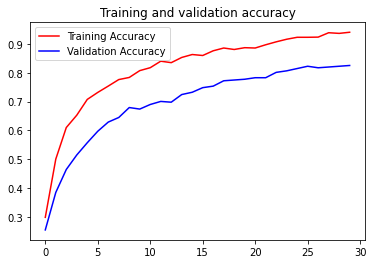

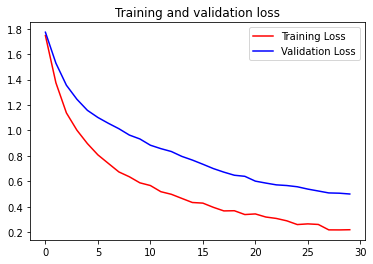

In [ ]:
acc=history.history['categorical_accuracy']
val_acc=history.history['val_categorical_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Test Accuracy Model

In [ ]:
loss = model.evaluate(test_generator, steps=len(test_generator))

24/24 [==============================] - 10s 411ms/step - loss: 0.4314 - categorical_accuracy: 0.8568


### Visualize accuracy each label or class with confusion matrix

reference : https://datatofish.com/confusion-matrix-python/

In [ ]:
# FIXED index order classes (https://github.com/keras-team/keras/issues/4225)
# Create new test generator with shuffle=False
new_test_generator = valtest_datagen.flow_from_directory(
    directory=test_dir,
    batch_size=batch_test,
    class_mode='categorical',
    target_size=size_input,
    shuffle=False # important part
)
new_test_generator.classes

Found 377 images belonging to 6 classes.


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [ ]:
predictions = model.predict(new_test_generator, steps=len(new_test_generator))

In [ ]:
# [FIXED] Problem order classes with set shuffle=False in test_generator
predictions_lb = np.argmax(predictions,axis=1)

In [ ]:
labels = new_test_generator.classes
confusion_matrix = tf.math.confusion_matrix(labels, predictions_lb)
print(confusion_matrix)

tf.Tensor(
[[51  1  1  5  1  1]
 [ 0 66  2  0  7  0]
 [ 0  3 55  0  3  0]
 [ 1  3  3 78  1  3]
 [ 0  2  4  2 62  2]
 [ 0  2  1  4  2 11]], shape=(6, 6), dtype=int32)


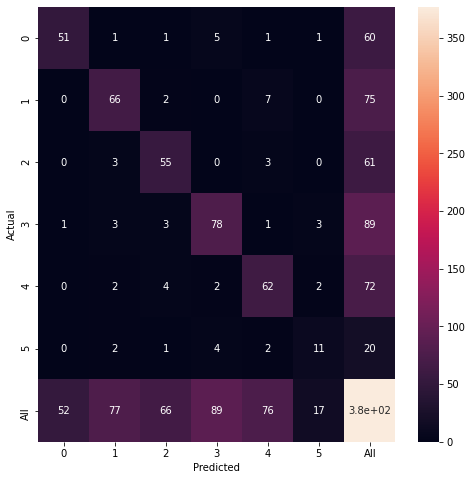

In [ ]:
data = {'y_Actual': labels,
        'y_Predicted': predictions_lb
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)
plt.figure(figsize = (8,8))
sn.heatmap(confusion_matrix, annot=True)
plt.show()

<table>
  <tr>
    <th colspan="6">Label Code</th>
  </tr>
  <tr align="center">
    <td>0</td>
    <td>1</td>
    <td>2</td>
    <td>3</td>
    <td>4</td>
    <td>5</td>
  </tr>
  <tr>
    <td>Cardboard</td>
    <td>Glass</td>
    <td>Metal</td>
    <td>Paper</td>
    <td>Plastic</td>
    <td>Trash</td>
  </tr>
</table>

More Details

In [ ]:
report = metrics.classification_report(
    labels, 
    predictions_lb, 
    target_names=label
)
print(report)

              precision    recall  f1-score   support

   cardboard       0.98      0.85      0.91        60
       glass       0.86      0.88      0.87        75
       metal       0.83      0.90      0.87        61
       paper       0.88      0.88      0.88        89
     plastic       0.82      0.86      0.84        72
       trash       0.65      0.55      0.59        20

    accuracy                           0.86       377
   macro avg       0.84      0.82      0.83       377
weighted avg       0.86      0.86      0.86       377



## Exporting and Optimization to TFLite

Reference :  
https://github.com/lmoroney/dlaicourse/blob/master/TensorFlow%20Deployment/Course%202%20-%20TensorFlow%20Lite/Week%201/Exercises/TFLite_Week1_Exercise.ipynb

In [ ]:
# Specifies the model directory
model_dir = '/tmp/model'
try:
  os.mkdir(model_dir)
except OSError as e:
  print("\nUnable create directory. {}".format(e))

In [ ]:
# Use the tf.saved_model API to save model in the SavedModel format
tf.saved_model.save(model, model_dir)

# Select mode of optimization
mode = "Default"

if mode == 'Storage':
  optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
  optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
  optimization = tf.lite.Optimize.DEFAULT

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: /tmp/model/assets


INFO:tensorflow:Assets written to: /tmp/model/assets




---



Reference : 
https://colab.research.google.com/github/tensorflow/examples/blob/master/lite/codelabs/digit_classifier/ml/step2_train_ml_model.ipynb#scrollTo=YvszGa11ne6Q

In [ ]:
# Convert Keras model to TF Lite format.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmp_xjmu_ls/assets


INFO:tensorflow:Assets written to: /tmp/tmp_xjmu_ls/assets


Float model size = 8693KBs.


In [ ]:
# [FIXED] : Error when optimizing with the quantization method due to an error in the input type and there is no "converter.representative_dataset" section.
# ref : https://medium.com/sclable/model-quantization-using-tensorflow-lite-2fe6a171a90d
def represent_data_gen():
  "It yields an image one by one"
  for i in range(len(test_generator.filenames)):
    img_with_lb = test_generator.next()
    yield [np.array(img_with_lb[0], dtype=np.float32, ndmin=2)] 

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [optimization]
converter.representative_dataset = represent_data_gen

# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# Re-convert the model to TF Lite using quantization.
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpls6_km25/assets


INFO:tensorflow:Assets written to: /tmp/tmpls6_km25/assets


Quantized model size = 2660KBs,
which is about 30% of the float model size.


In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_quantized_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


### Test and Evaluate Tflite Model with TFLite Interpreter (before download)

In [ ]:
def evaluate_tflite_model(tflite_model):
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # Run predictions on every image in the "test" dataset.
  predictions = []
  for test_image in list_test_img[:15]:
    
    # [FIXED] Input data type error, Previous error of type tf.float32, it should be tf.int8
    # Check if the input type is quantized, then rescale input data to uint8
    # ref : https://www.tensorflow.org/lite/performance/post_training_integer_quant
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point
    
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    # Post-processing: remove batch dimension and find the digit with highest probability.
    predictions.append(output.argmax())

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(predictions)):
    if predictions[index] == np.argmax(list_test_lb[index]):
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(predictions)

  return accuracy

In [ ]:
# Evaluate the TF Lite float model.
float_accuracy = evaluate_tflite_model(tflite_float_model)
print('Float model accuracy = %.4f' % float_accuracy)

# Evalualte the TF Lite quantized model.
quantized_accuracy = evaluate_tflite_model(tflite_quantized_model)
print('Quantized model accuracy = %.4f' % quantized_accuracy)
gap_acc = float_accuracy - quantized_accuracy
if gap_acc >= 0:
  print('Accuracy drop = %.4f' % (gap_acc))
else:
  print('Accuracy increase = %.4f' % (-1*gap_acc))

Float model accuracy = 0.8667
Quantized model accuracy = 0.8667
Accuracy drop = 0.0000


### Download TFlite Model

Float Model

In [ ]:
# Save the float model to file to the Downloads directory
f = open('/tmp/model/model-float-tl.tflite', "wb")
f.write(tflite_float_model)
f.close()

# Download the garbage detection model
files.download('/tmp/model/model-float-tl.tflite')

print('`model-float-tl.tflite` has been downloaded')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`model-float-tl.tflite` has been downloaded


Quantization Model

In [ ]:
# Save the quantized model to file to the Downloads directory
f = open('/tmp/model/model-quant-tl.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

# Download the garbage_detection model
files.download('/tmp/model/model-quant-tl.tflite')

print('`model-quant-tl.tflite` has been downloaded')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`model-quant-tl.tflite` has been downloaded


## Summary

<table>
<tr><th colspan=2>TEST ACCURACY<br/><br/>with 70/15/15 ~ train/val/test</th></tr>
<tr>
  <td>w/o Transfer Learning</td>
  <td>w/ Transfer learning</td>
</tr>
<tr>
  <td>74.54%</td>
  <td>85.68%</td>
</tr>
</table>

Comparison of accuracy after being converted into tflite, with the model used is a model with transfer learning. Considering the resulting accuracy is higher.

<table>
<tr>
  <td>Float Model</td>
  <td>Quantization Model</td>
</tr>
<tr><th colspan=2>TEST ACCURACY TFLITE</th></tr>
<tr>
  <td>86.67%</td>
  <td>86.67%</td>
</tr>
<tr>
<th colspan=2>MODEL SIZE</th>
</tr>
<tr>
<td>8693KBs</td>
<td>2660KBs</td>
</tr>
</table>